In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

d:\EKKE_MSc\machine_learning gy\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\EKKE_MSc\machine_learning gy\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\EKKE_MSc\machine_learning gy\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [16]:
DATASET_NAME = "PedroSampaio/fruits-360"
TARGET_SIZE = (100, 100) 
BATCH_SIZE = 32
SPLIT_SEED = 42

from datasets import load_dataset
full_train_data = load_dataset(DATASET_NAME, split='train', streaming=False)
raw_test_stream = load_dataset(DATASET_NAME, split='test', streaming=True)

split_datasets = full_train_data.train_test_split(test_size=0.2, seed=SPLIT_SEED)

hf_train = split_datasets['train']
hf_validation = split_datasets['test']
ALL_CLASSES = full_train_data.features['label'].names
NUM_CLASSES = len(ALL_CLASSES)

def preprocess(example):
    image = np.array(example['image'].convert("RGB"))
    image = image / 255.0
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.image.resize(image_tensor, size=TARGET_SIZE)
    label_id = example['label']

    return image_tensor, label_id

def data_generator(hf_data):
    for example in hf_data:
        yield preprocess(example)

example_image, example_label = preprocess(next(iter(hf_train)))
OUTPUT_SHAPE = (example_image.shape, ()) # e.g., (128, 128, 3), ()
OUTPUT_TYPES = (tf.float32, tf.int32) 

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(hf_train), 
    output_types=OUTPUT_TYPES,
    output_shapes=OUTPUT_SHAPE
).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(hf_validation), 
    output_types=OUTPUT_TYPES,
    output_shapes=OUTPUT_SHAPE
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(raw_test_stream),
    output_types=OUTPUT_TYPES,
    output_shapes=OUTPUT_SHAPE
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow import constantycxv

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation=LeakyReLU(0.4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (2, 2), activation=LeakyReLU(0.25)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(8, (2, 2), activation=LeakyReLU(0.25)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(8, (2, 2), activation=LeakyReLU(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation=LeakyReLU(0.25)))
model.add(Dropout(0.25))
model.add(Dense(16, activation=LeakyReLU(0.25)))
model.add(Dense(16, activation=LeakyReLU(0.25))) 

model.add(Dense(NUM_CLASSES, activation='softmax')) 


d:\EKKE_MSc\machine_learning gy\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 31, 31, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 9, 9, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 3, 3, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 2, 2, 8)        │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 1, 1, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 113)            │         1,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,881 (26.88 KB)

 Trainable params: 6,817 (26.63 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [
    early_stopping_callback
]

In [31]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks_list
)
print("Training complete.")

Epoch 1/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 246s 144ms/step - accuracy: 0.2124 - loss: 2.8700 - val_accuracy: 0.4388 - val_loss: 1.7497
Epoch 2/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 260s 153ms/step - accuracy: 0.4470 - loss: 1.7019 - val_accuracy: 0.6186 - val_loss: 1.1962
Epoch 3/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 254s 150ms/step - accuracy: 0.5631 - loss: 1.3158 - val_accuracy: 0.7284 - val_loss: 0.8189
Epoch 4/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 241s 142ms/step - accuracy: 0.6297 - loss: 1.0933 - val_accuracy: 0.7573 - val_loss: 0.7273
Epoch 5/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 244s 143ms/step - accuracy: 0.6747 - loss: 0.9577 - val_accuracy: 0.7743 - val_loss: 0.6860
Epoch 6/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 246s 145ms/step - accuracy: 0.7060 - loss: 0.8569 - val_accuracy: 0.8574 - val_loss: 0.4568
Epoch 7/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 248s 146ms/step - accuracy: 0.7317 - loss: 0.7763 - val_accuracy: 0.8722 - val_loss: 0.4166
Epoch 8/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 242s 142ms/s

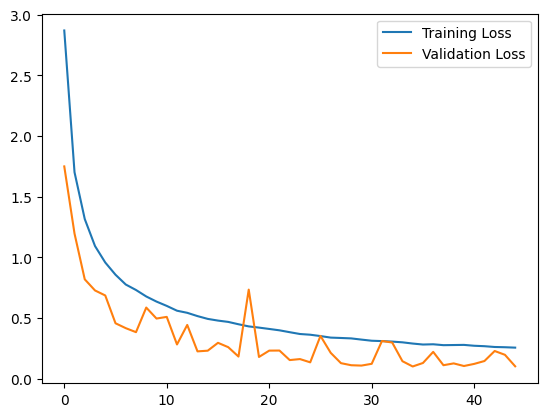

In [35]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

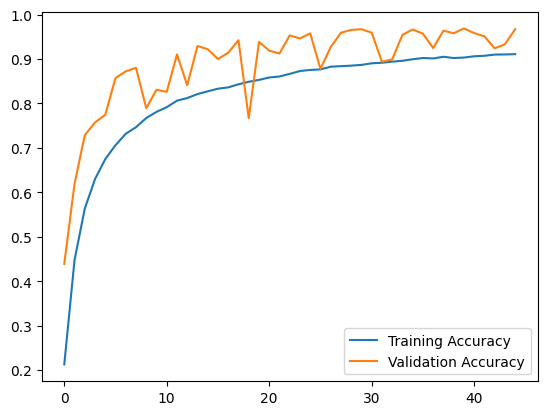

In [36]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [39]:
test_results = model.evaluate(
    test_dataset,
    steps=1693,
    verbose=1
)

# test_results will contain [loss, accuracy]
final_test_loss = test_results[0]
final_test_accuracy = test_results[1]

print(f"\nFinal Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy*100:.2f}%")

1693/1693 ━━━━━━━━━━━━━━━━━━━━ 49s 25ms/step - accuracy: 0.8988 - loss: 0.3421

Final Test Loss: 0.3421
Final Test Accuracy: 89.88%


In [40]:
from tensorflow.keras.saving import save_model
save_model(filepath='models/model.keras', overwrite=True, save_format="keras", model=model)